In [1]:
# TODO: This needs to be updated to use mutation AA positions rather than residue position
from biopandas.pdb import PandasPdb
# pdf = PandasPdb().read_pdb('/home/pphaneuf/iML1515_GP/iML1515_GP/genes/b3926/b3926_protein/structures/GLPK_ECOLI_model1_clean.pdb')
pdf = PandasPdb().read_pdb('../data/pdb_files/KPYK1_ECOLI_model1_clean.pdb')  # From iML1515
adf = pdf.df['ATOM']
cadf = adf[adf["atom_name"]=="CA"]
cadf = cadf.set_index("residue_number")
cadf = cadf[cadf["alt_loc"].isin(['A', ''])]  # removing the 'B' residue alternative locations. I could also find the average between the two positions if necessary to account for both.
cadf.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
residue_number,,,,,,,,,,,,,,,,,,,,
1,ATOM,2,,CA,,MET,,X,,,-17.124,9.151,94.383,0.0,74.18,,1SG,C,NaN,1
2,ATOM,10,,CA,,LYS,,X,,,-13.670,9.604,92.938,0.0,142.84,,1SG,C,NaN,9
3,ATOM,19,,CA,,LYS,,X,,,-11.232,11.309,95.268,0.0,74.17,,1SG,C,NaN,18
4,ATOM,28,,CA,,THR,,X,,,-8.478,11.977,92.760,0.0,62.70,,1SG,C,NaN,27
5,ATOM,35,,CA,,LYS,,X,,,-8.811,14.945,90.461,0.0,105.62,,1SG,C,NaN,34


In [2]:
import pandas as pd

aa_mut_cnt_df = pd.read_csv("./pykF_pub_aa_muts.csv")
aa_mut_cnt_df = aa_mut_cnt_df[aa_mut_cnt_df["study"]=="TOL_isobutyric_acid"]
aa_mut_cnt_df.head()

,AA position,mutation count,name,color,study,study color
0,20,1,MOB AA 20,#CF000F,TOL_isobutyric_acid,#9467BD
5,129,1,SNP AA 129,#8C564B,TOL_isobutyric_acid,#9467BD
7,174,1,SNP AA 174,#8C564B,TOL_isobutyric_acid,#9467BD
11,246,1,SNP AA 246,#FFA500,TOL_isobutyric_acid,#9467BD
14,266,2,INS AA 266,#CF000F,TOL_isobutyric_acid,#9467BD


In [3]:
gff_df = pd.read_csv("./PykF_feats.csv")
gff_df = gff_df[~(gff_df.feature.isin(["Turn", "Helix", "Beta strand", "Barrel domain", "Alpha/beta domain"]))].copy()
gff_df.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,9,color
0,P0AD61,UniProtKB,Chain,1,470,.,.,.,ID=PRO_0000112069;Note=Pyruvate kinase I,NaN,white
1,P0AD61,UniProtKB,ATP binding site,34,37,.,.,.,Note=ATP;Ontology_term=ECO:0000250;evidence=EC...,NaN,#FFC125
2,P0AD61,UniProtKB,Potassium binding site,34,34,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00
3,P0AD61,UniProtKB,Potassium binding site,36,36,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00
4,P0AD61,UniProtKB,Potassium binding site,66,66,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00


In [4]:
aa_mut_cnt_df = aa_mut_cnt_df[aa_mut_cnt_df["color"] != "#CF000F"].copy()  # filtering out all truncating mutations since currently not considering truncations for 3D clustering

dist_aa_df = aa_mut_cnt_df.copy()

# don't care about about multiple muts on same AA for now
dist_aa_df = dist_aa_df[["AA position", "name", "study"]]
dist_aa_df = dist_aa_df.drop_duplicates()
# display(dist_aa_df)

for _, r in gff_df.iterrows():
    if r["feature"] != "Chain":
        for aa in range(r["start"], r["end"] + 1): 
            dist_aa_df = dist_aa_df.append({"AA position":aa, "name": r["feature"] + " AA " + str(aa)}, ignore_index=True)

dist_aa_df["AA position"] = dist_aa_df["AA position"].astype(int)

# PykF using includes the initiator methionine.
dist_aa_df["residue index"] = dist_aa_df["AA position"] # - 1  # this really depends on the structure being used. Double check if the initiator methionine is included in structure.

dist_aa_df['coords'] = dist_aa_df.apply(lambda r:
                                        [
                                            cadf.at[r["residue index"], "x_coord"],
                                            cadf.at[r["residue index"], "y_coord"],
                                            cadf.at[r["residue index"], "z_coord"],
                                        ],
                                        axis=1)
dist_aa_df.head()

,AA position,name,study,residue index,coords
0,129,SNP AA 129,TOL_isobutyric_acid,129,"[15.355, 9.613, 68.956]"
1,174,SNP AA 174,TOL_isobutyric_acid,174,"[7.472, 32.815, 79.0]"
2,246,SNP AA 246,TOL_isobutyric_acid,246,"[10.504, 13.745, 79.934]"
3,314,SNP AA 314,TOL_isobutyric_acid,314,"[-5.825, 12.826, 74.747]"
4,34,ATP binding site AA 34,NaN,34,"[-0.606, 24.581, 77.12]"


In [5]:
import numpy as np
def _get_dist_mat_label(r):
    lbl = r["name"]
    if ("SNP" in r["name"]) or ("INS" in r["name"]):
        lbl = "mut AA " + str(r["AA position"])
    return lbl
        

dist_aa_df['dist mat label'] = dist_aa_df.apply(lambda r: _get_dist_mat_label(r), axis=1)
# dist_aa_df = dist_aa_df.set_index("AA position")
dist_aa_df = dist_aa_df.set_index("dist mat label")

dist_aa_df.head()

,AA position,name,study,residue index,coords
dist mat label,,,,,
mut AA 129,129,SNP AA 129,TOL_isobutyric_acid,129,"[15.355, 9.613, 68.956]"
mut AA 174,174,SNP AA 174,TOL_isobutyric_acid,174,"[7.472, 32.815, 79.0]"
mut AA 246,246,SNP AA 246,TOL_isobutyric_acid,246,"[10.504, 13.745, 79.934]"
mut AA 314,314,SNP AA 314,TOL_isobutyric_acid,314,"[-5.825, 12.826, 74.747]"
ATP binding site AA 34,34,ATP binding site AA 34,NaN,34,"[-0.606, 24.581, 77.12]"


In [6]:
import numpy as np


def get_AA_dist(aa1, aa2):
    AA_dist = np.nan
    aa1_coords = dist_aa_df.at[aa1, "coords"]
    aa2_coords = dist_aa_df.at[aa2, "coords"]
    AA_dist = np.sqrt((aa2_coords[0] - aa1_coords[0])**2
                      + (aa2_coords[1] - aa1_coords[1])**2
                      + (aa2_coords[2] - aa1_coords[2])**2)
    return AA_dist


dist_mat = pd.DataFrame(np.nan, columns=dist_aa_df.index, index=dist_aa_df.index)
for ir in dist_mat.index:
    for ic in dist_mat.columns:
        dist_mat.at[ir, ic] = get_AA_dist(ir, ic)
dist_mat.head()

dist mat label,mut AA 129,mut AA 174,mut AA 246,mut AA 314,ATP binding site AA 34,ATP binding site AA 35,ATP binding site AA 36,ATP binding site AA 37,Potassium binding site AA 34,Potassium binding site AA 36,...,PykF subunit interface AA 255,PykF subunit interface AA 256,PykF subunit interface AA 257,PykF subunit interface AA 291,PykF subunit interface AA 292,PykF subunit interface AA 293,PykF subunit interface AA 294,PykF subunit interface AA 295,PykF subunit interface AA 296,PykF subunit interface AA 297
dist mat label,,,,,,,,,,,,,,,,,,,,,
mut AA 129,0.000000,26.483135,12.693388,22.191247,23.354773,24.106115,20.570546,22.131721,23.354773,20.570546,...,19.580160,18.357043,21.312404,23.254461,25.513162,22.599739,22.026009,25.724485,25.872862,23.189981
mut AA 174,26.483135,0.000000,19.332105,24.381516,11.687054,8.549777,9.491453,11.903938,11.687054,9.491453,...,30.065423,27.576021,29.712806,34.971009,37.179521,35.043936,31.883754,33.564942,34.850815,31.511138
mut AA 246,12.693388,19.332105,0.000000,17.157674,15.772431,17.252794,14.986260,17.929071,15.772431,14.986260,...,12.631050,9.868855,12.643514,20.370237,21.903351,18.722337,16.846715,19.617447,19.569503,15.945456
mut AA 314,22.191247,24.381516,17.157674,0.000000,13.078575,16.567318,15.947117,15.535124,13.078575,15.947117,...,25.855307,22.148120,22.075165,13.250782,16.236302,16.033514,12.565899,13.769849,16.912331,15.573471
ATP binding site AA 34,23.354773,11.687054,15.772431,13.078575,0.000000,3.797461,5.289056,6.254984,0.000000,5.289056,...,27.204501,23.776046,24.963153,24.945940,27.433374,26.029869,22.496995,23.867602,25.966133,23.213668


In [7]:
df = gff_df[["feature", "color"]].drop_duplicates()
feat_to_color_d = dict()
for _, r in df.iterrows():
    feat_to_color_d[r["feature"]] = r["color"]
feat_to_color_d

{'Chain': 'white',
 'ATP binding site': '#FFC125',
 'Potassium binding site': '#76EE00',
 'Magnesium binding site': '#42d4f4',
 'Substrate binding site': '#911EB4',
 'Transition state stabilizer': '#4169E1',
 'N6-acetyllysine site': '#FA8072',
 'PykF subunit interface': '#88D27A'}

In [8]:
AA_feat_dist_df = dist_mat[dist_mat.index.str.contains("mut")]
AA_feat_dist_df = AA_feat_dist_df.T
AA_feat_dist_df = AA_feat_dist_df[~(AA_feat_dist_df.index.str.contains("mut"))]

col_colors = []
for _, r in AA_feat_dist_df.iterrows():
    col_colors.append(feat_to_color_d[r.name[:r.name.find(" AA")]])
# col_colors

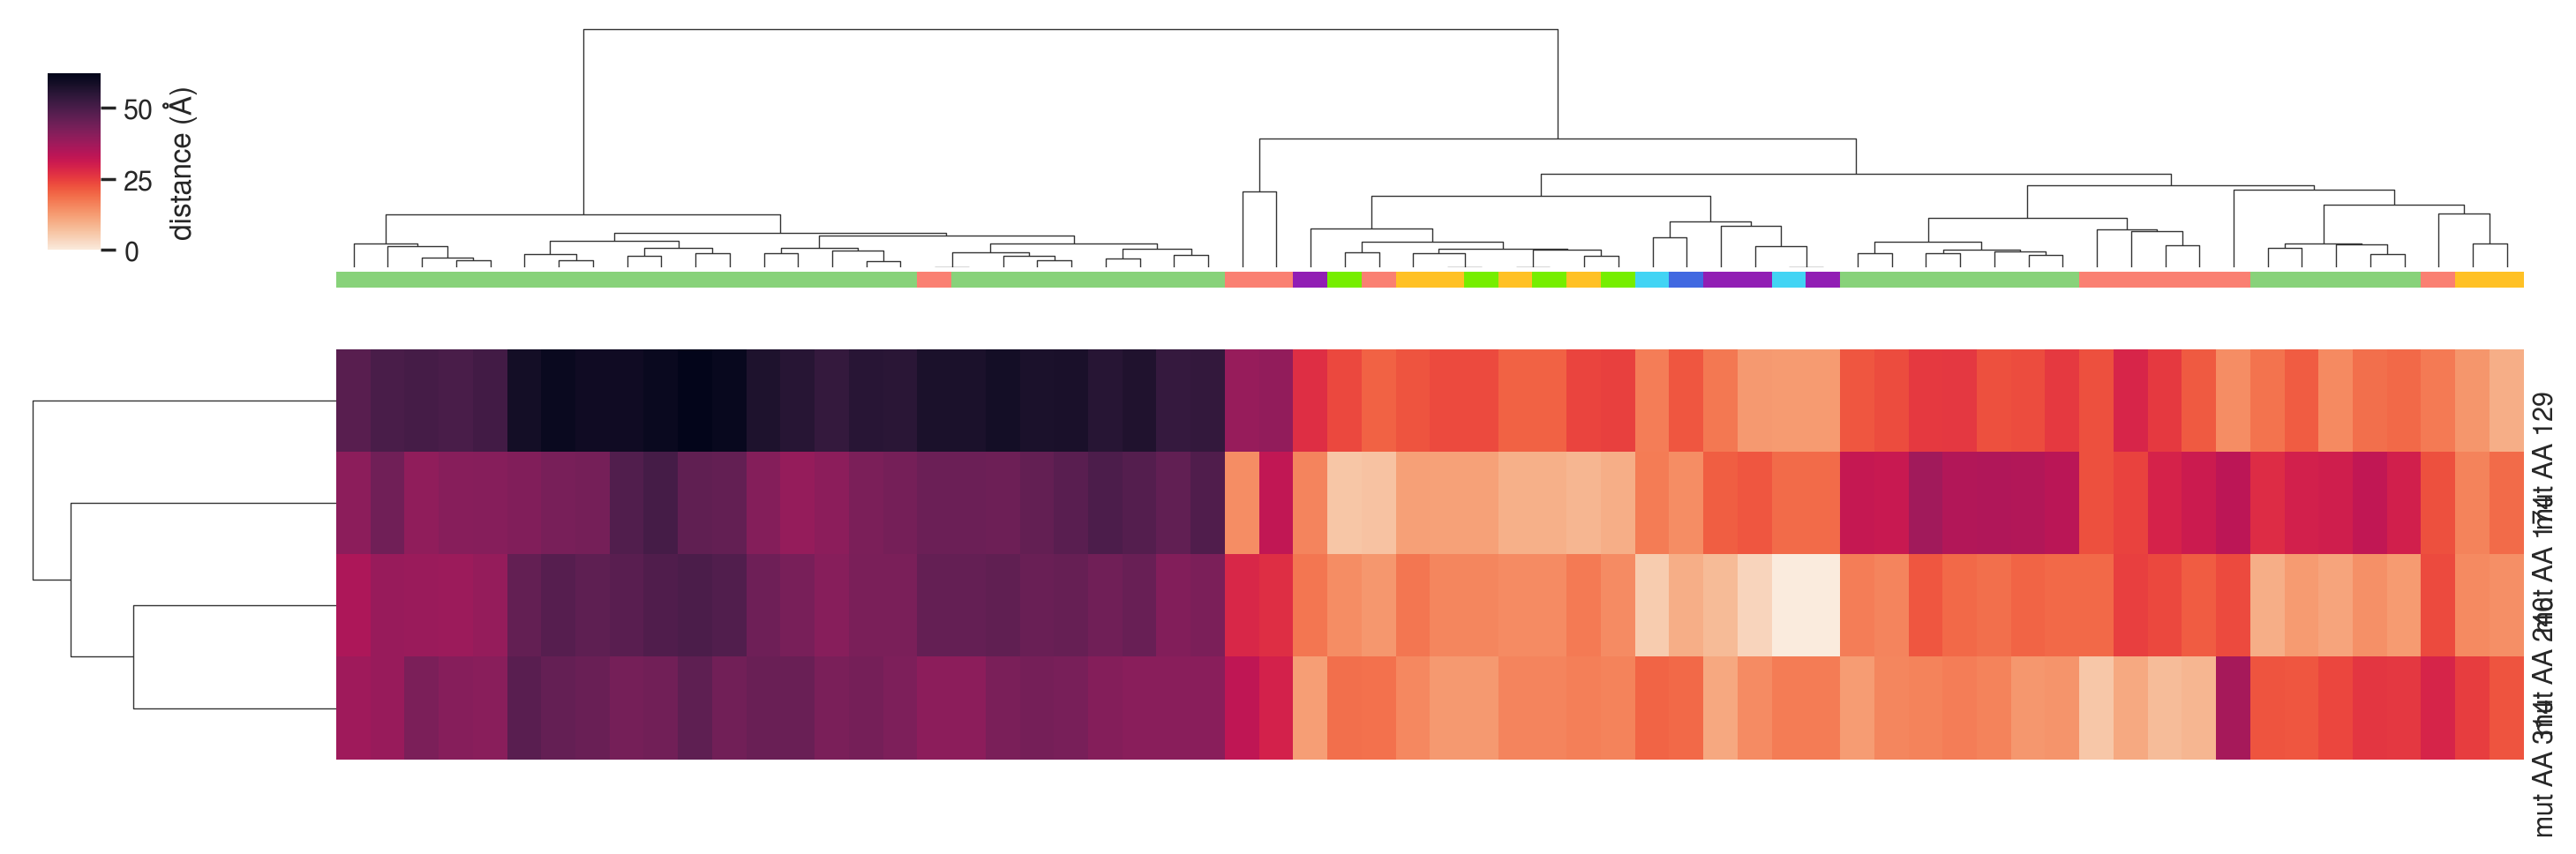

In [9]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as mpl
%matplotlib inline
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['font.sans-serif'] = ["FreeSans"]
sns.set_context("paper")
sns.set_style("white")
sns.set(font="FreeSans")

df = AA_feat_dist_df.T
cm = sns.clustermap(
    df,
#     linewidths=0.1,
    cbar_kws={'label': 'distance (Å)'},
    cbar_pos=(0.05, 0.85, 0.03, 0.10),
    yticklabels=True,
    xticklabels=True,
#     annot=True,
    cmap="rocket_r",
    col_colors=col_colors,
#     figsize=(10,10)
)
# Fix for recent matplotlib/seaborn issue
cm.ax_heatmap.set_ylim(len(df)+0, -0)

# Below is for adjusting the sizes of the dendograms and heatmaps
H = 0.425
W = 1.7
y0_offset = 0.29
x0_offset = 0.01
hm = cm.ax_heatmap.get_position()
# mpl.setp(cm.ax_heatmap.yaxis.get_majorticklabels(),fontsize=6)
# mpl.setp(cm.ax_heatmap.xaxis.get_majorticklabels(),fontsize=6)
col_dendo = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([
    col_dendo.x0 + x0_offset,
    col_dendo.y0,
    col_dendo.width*W,
    col_dendo.height*1
])
row_dendo = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([
    row_dendo.x0 + 0.015,
    row_dendo.y0 + y0_offset,
    row_dendo.width*1,
    row_dendo.height*H
])
cm.ax_heatmap.set_position([
    hm.x0 + x0_offset,
    hm.y0 + y0_offset,
    hm.width*W,
    hm.height*H
])
col_color_pos = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([
    col_color_pos.x0 + 0.01,
    col_color_pos.y0 + 0.01,
    col_color_pos.width*W,
    col_color_pos.height*H
])

# mpl.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)
# cm.fig.suptitle("3D distance between mutated AA and small active sites on GlpK", y=0.92, x=0.6)

In [10]:
mut_aa_feat_prox_df = pd.DataFrame()
df = AA_feat_dist_df.T
for mut_aa, r in df.iterrows():
    min_dist_feats = r[r==r.min()]
    for feat_AA, min_dist in min_dist_feats.iteritems():
        feat = feat_AA[:feat_AA.find(" AA ")]
        mut_aa_feat_prox_df = mut_aa_feat_prox_df.append({"mut AA": mut_aa.replace("mut AA ", ''), "nearest feature": feat}, ignore_index=True)
mut_aa_feat_prox_df

,mut AA,nearest feature
0,129,ATP binding site
1,174,Potassium binding site
2,246,Magnesium binding site
3,246,Substrate binding site
4,314,N6-acetyllysine site


In [11]:
# TODO: change "gly_glpK" to "gene" when everthing work
gly_glpK_mut_df = pd.read_pickle("./pykF_mut_df.pkl")

gly_glpK_mut_df = gly_glpK_mut_df[gly_glpK_mut_df["exp"]=="TOL_isobutyric_acid"]

gly_glpK_mut_df.head()

,COG links,COGs,Details,EC number links,EC numbers,Mutation Type,Position,RBS,Reference Seq,Sequence Change,...,tech_rep,temperature,terminator,mutation size,truncation,AA range,subgenic features,AA change,conservation (SIFT),stability (ΔΔGpred)
8,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,coding (58‑61/1413 nt),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",MOB,1755755.0,{},NC_000913,IS5 (–) +4 bp,...,1.0,37 celsius,{},1199,True,"(20, 20)","{Barrel domain, Helix}",,False,False
9,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,E314Q (GAA→CAA),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756637.0,{},NC_000913,G→C,...,1.0,37 celsius,{},1,False,"(314, 314)","{Barrel domain, Helix}",E314Q,True,False
10,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,L129P (CTG→CCG),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756083.0,{},NC_000913,T→C,...,1.0,37 celsius,{},1,False,"(129, 129)","{Barrel domain, Turn}",L129P,True,True
11,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,coding (1385‑1387/1413 nt),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",MOB,1757082.0,{},NC_000913,+G :: IS5 (–) +3 bp,...,1.0,37 celsius,{},1199,True,"(462, 462)",{Alpha/beta domain},,False,False
12,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,coding (1197/1413 nt),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",INS,1756894.0,{},NC_000913,+TG,...,1.0,37 celsius,{},2,True,"(399, 399)","{Alpha/beta domain, Beta strand}",,False,False


In [12]:
mut_aa_feat_prox_df = mut_aa_feat_prox_df.set_index("mut AA")
mut_aa_feat_prox_df

,nearest feature
mut AA,
129,ATP binding site
174,Potassium binding site
246,Magnesium binding site
246,Substrate binding site
314,N6-acetyllysine site


In [13]:
aa_mut_effect_df = pd.DataFrame(columns=["mutated AA", "functionally disruptive", "structurally disruptive", "nearest feature"])
for _, m in gly_glpK_mut_df.iterrows():
    if m["AA range"][0] == m["AA range"][1]:
        aa = m["AA range"][0]
        for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
            aa_mut_effect_df = aa_mut_effect_df.append({
                "mutated AA": aa,
                "functionally disruptive": m["conservation (SIFT)"],
                "structurally disruptive": m["stability (ΔΔGpred)"],
                "nearest feature": r["nearest feature"]},
                ignore_index=True)
    else:
        for aa in m["AA range"]:
            for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
                aa_mut_effect_df = aa_mut_effect_df.append({
                    "mutated AA": aa,
                    "functionally disruptive": m["conservation (SIFT)"],
                    "structurally disruptive": m["stability (ΔΔGpred)"],
                    "nearest feature": r["nearest feature"]},
                    ignore_index=True)

aa_mut_effect_df["unknown"] = aa_mut_effect_df.apply(lambda r: True if ((r["functionally disruptive"]==False) & (r["structurally disruptive"]==False)) else False, axis=1)
aa_mut_effect_df.head()

,mutated AA,functionally disruptive,structurally disruptive,nearest feature,unknown
0,314,True,False,N6-acetyllysine site,False
1,129,True,True,ATP binding site,False
2,174,True,True,Potassium binding site,False
3,246,True,False,Magnesium binding site,False
4,246,True,False,Substrate binding site,False


In [14]:
aa_mut_effect_df.to_pickle("./PykF_IBUA_mut_res_df.pkl")  # Since this also describes the frequency of mutated residues, using it to described freq mut res per feat.

In [15]:
cnt_columns = ["unknown", "functionally disruptive", "structurally disruptive"]
feat_mut_eff_cnt_d = {f:{"functionally disruptive":0, "structurally disruptive":0, "unknown":0} for f in aa_mut_effect_df["nearest feature"].unique()}
for nf, gdf in aa_mut_effect_df.groupby("nearest feature"):
    for _, r in gdf.iterrows():
        f = r["nearest feature"]
        for c in cnt_columns:
            feat_mut_eff_cnt_d[f][c] += int(r[c])
feat_mut_eff_cnt_d

{'N6-acetyllysine site': {'functionally disruptive': 1,
  'structurally disruptive': 0,
  'unknown': 0},
 'ATP binding site': {'functionally disruptive': 1,
  'structurally disruptive': 1,
  'unknown': 0},
 'Potassium binding site': {'functionally disruptive': 1,
  'structurally disruptive': 1,
  'unknown': 0},
 'Magnesium binding site': {'functionally disruptive': 1,
  'structurally disruptive': 0,
  'unknown': 0},
 'Substrate binding site': {'functionally disruptive': 1,
  'structurally disruptive': 0,
  'unknown': 0}}

In [16]:
cnt_df = pd.DataFrame(feat_mut_eff_cnt_d).T
cnt_df["total"] = cnt_df.sum(axis=1)
cnt_df

,functionally disruptive,structurally disruptive,unknown,total
N6-acetyllysine site,1,0,0,1
ATP binding site,1,1,0,2
Potassium binding site,1,1,0,2
Magnesium binding site,1,0,0,1
Substrate binding site,1,0,0,1


In [17]:
cnt_df.to_pickle("./isobutyric_acid_pykF_mut_nearest_feat_df.pkl")